# 01.PyTorch工作流基础知识（workflow）
机器学习和深度学习的本质是从过去获取一些数据，构建一个算法（如神经网络）来发现其中的模式，并利用发现的模式预测未来。



## 涵盖的内容
本模块中，将介绍一个标准的PyTorch工作流程，可以根据需要进行调整，但是下图涵盖了主要的步骤大纲

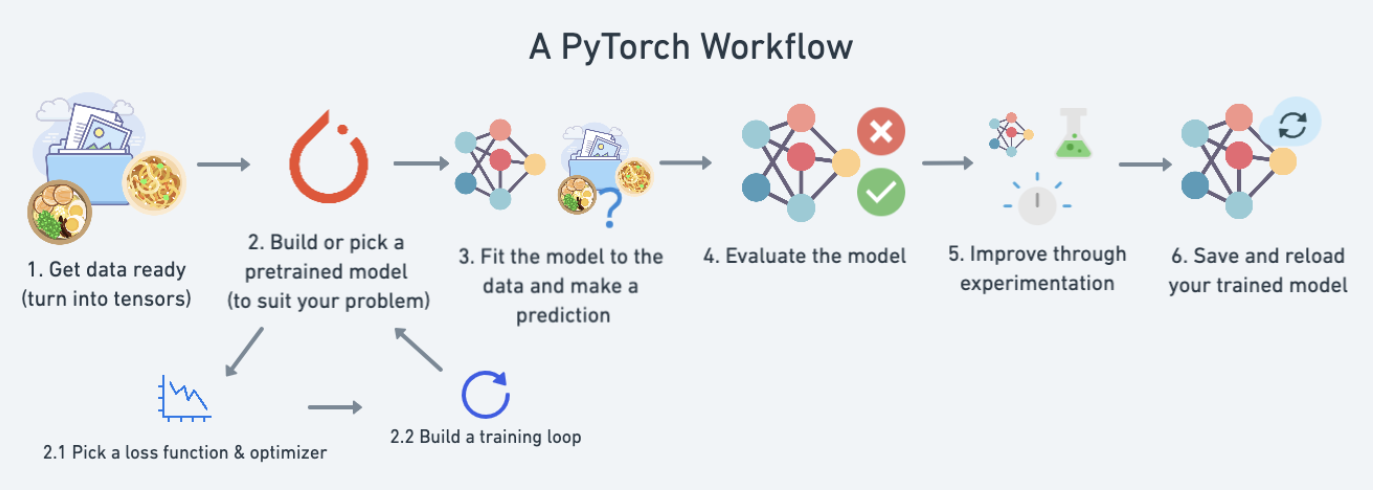

目前，使用工作流程来预测一条简单的直线。工作流程可以根据正在处理的问题进行重复和更改。

具体来说：

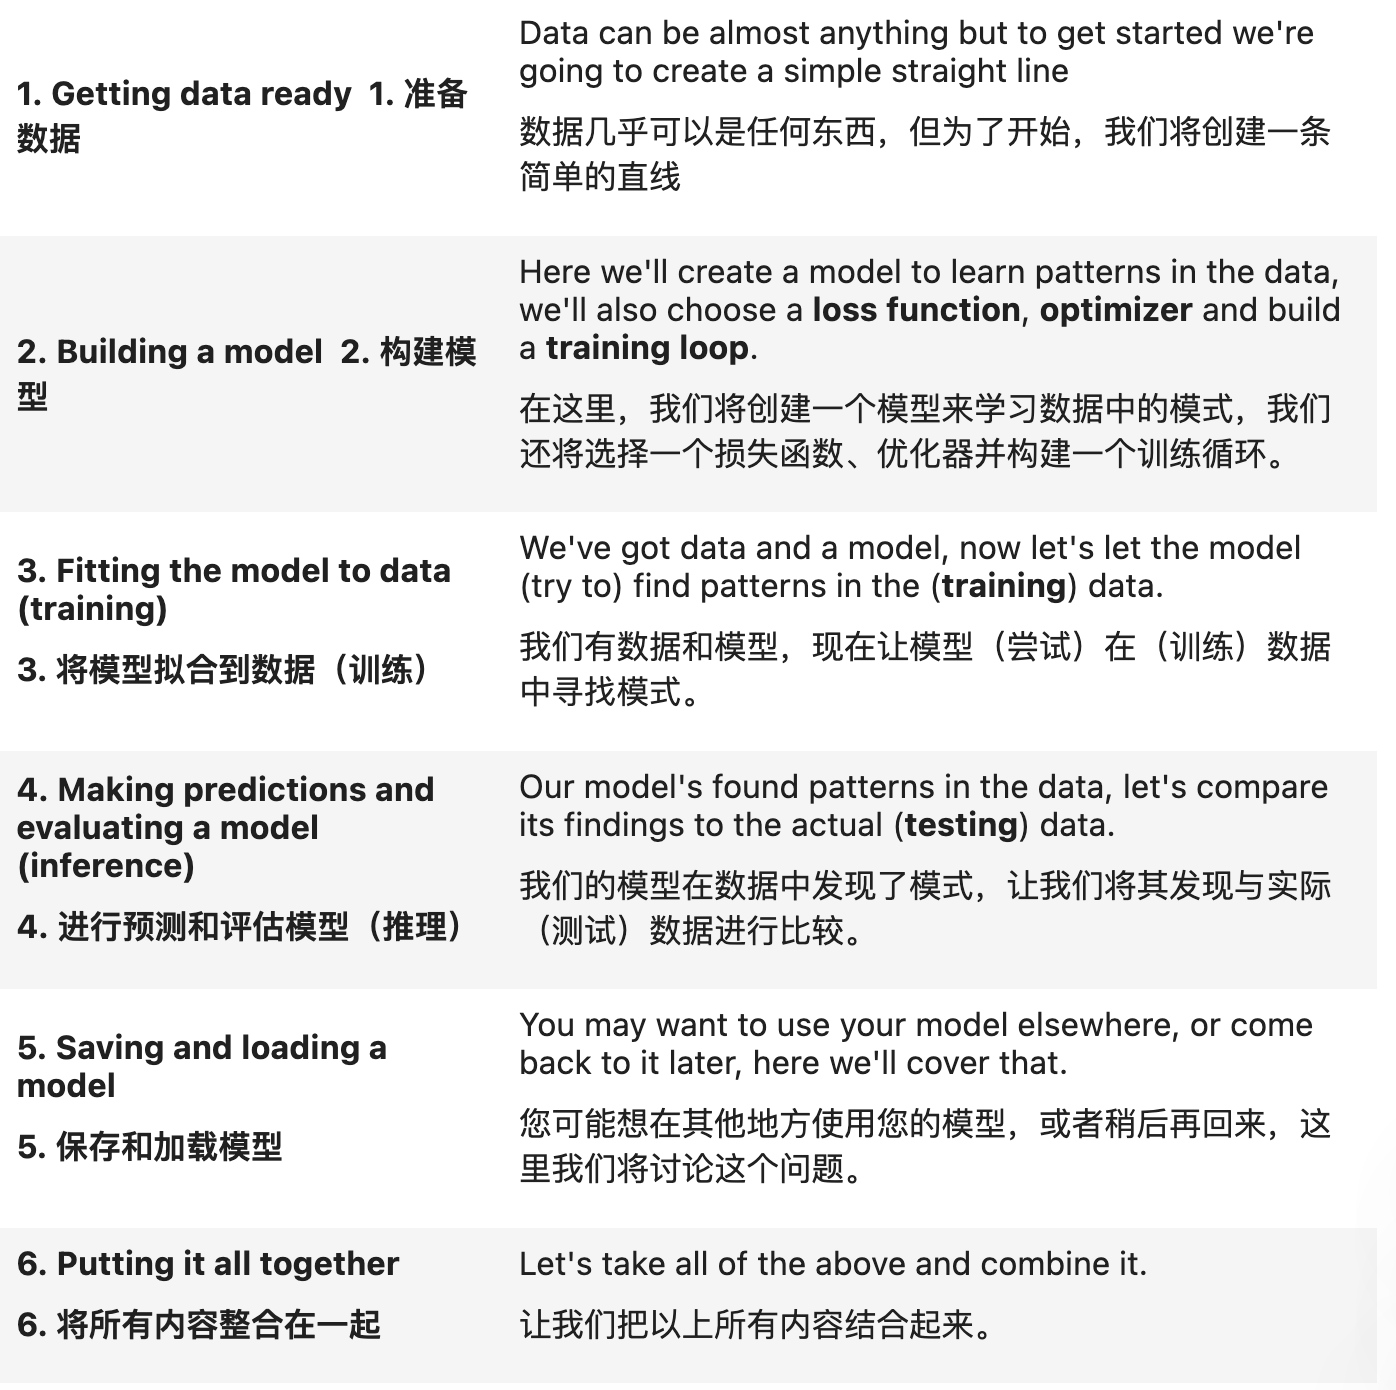

将步骤放在一个字典中，以便稍后参考

```python
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}
```

首先到导入包

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu118'

### 1. 数据（准备和加载）
数据可以使任何东西，文本、音频、图像等等
可以是你任何想到的东西。

机器学习是由两个部分组成的游戏：
1. 将数据，无论是什么，转化为数字
1. 选择或构建一个模型，以尽可能好地学习表示

如果没有数据，那就创造数据。

首先基于设置已知参数来生成数据。

In [2]:
# 设置已知参数
weight = 0.7
bias = 0.3

# 创造数据
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze()函数增加一个特征维度。
y = weight * X + bias



X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

现在就可以着手构建一个学习`X`(特征)和`y`(标签)之间关系的模型。

训练完成之后，和我们已知设置的参数对比，去评估误差率

### 将数据集分为训练集和测试集
机器学习最重要的步骤之一就是创建训练集和测试集（如有需要，还要创建验证集）。

数据集划分的特定目的如下：

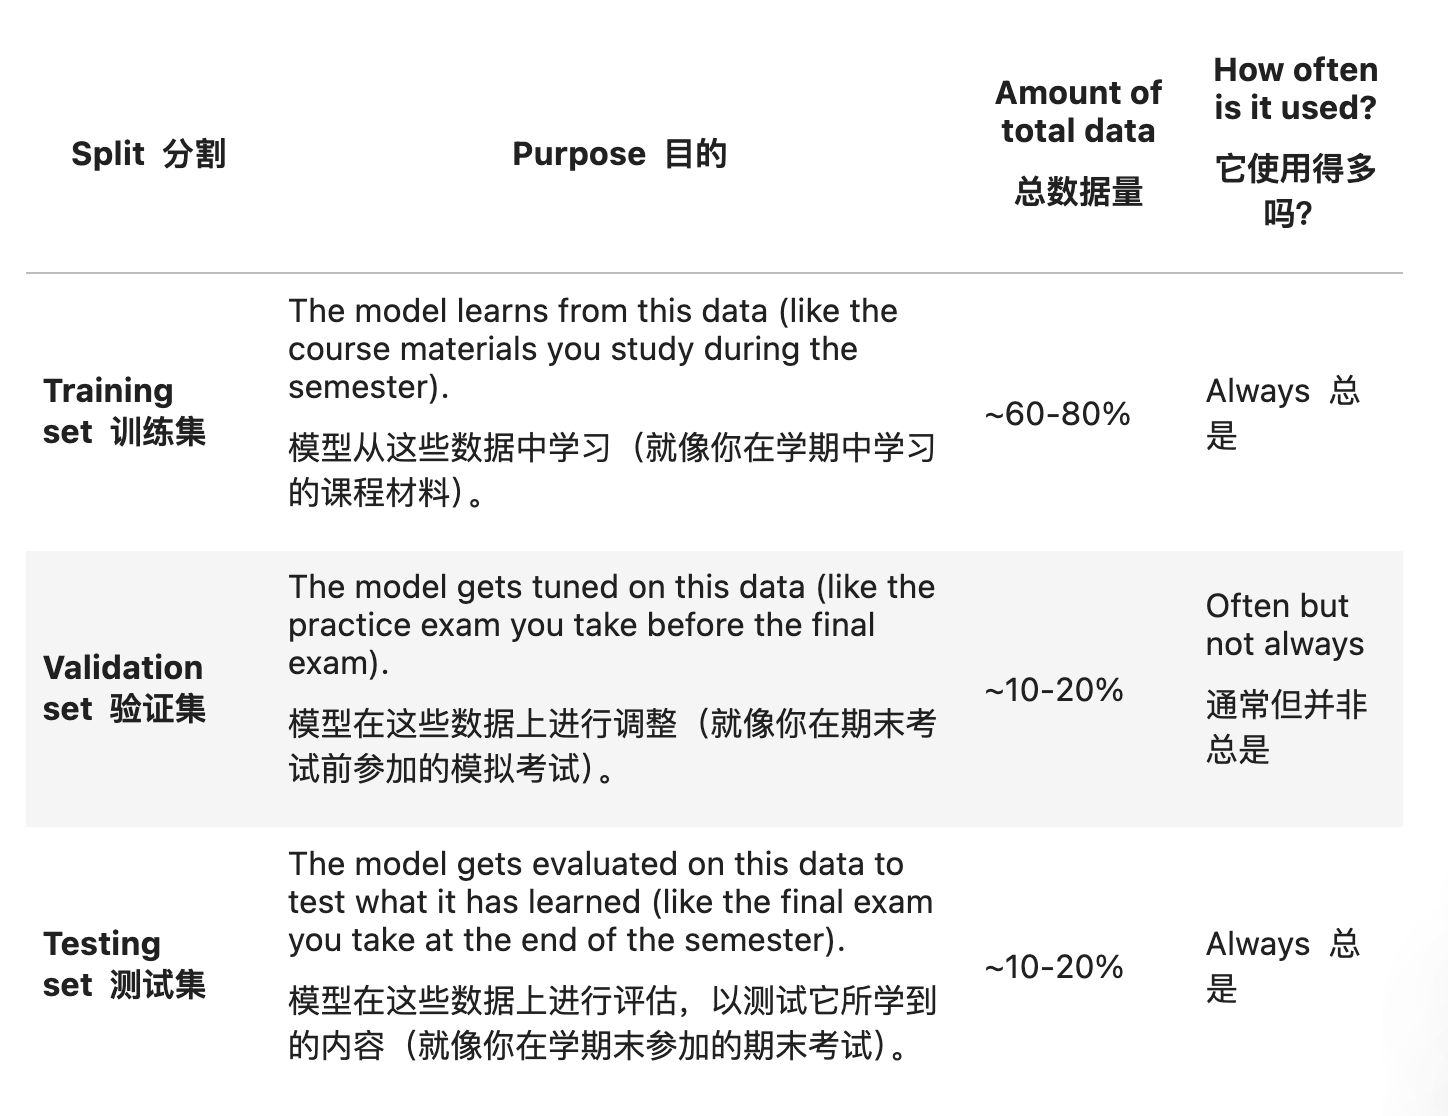

目前只使用训练集和测试集，意味着有一个数据集供模型学习和评估。

通过拆分`X`和`y`张量来创建它们（训练集和测试集）

在处理真实世界数据的时候，这一步通常在项目开始时就完成（测试集应始终与所有其他数据分开）。希望模型从训练数据中学习，然后在测试数据上进行评估，以了解它在未见示例上的泛化能力。

In [3]:
# 创建训练/测试分开集
train_split = int(0.8 * len(X)) # 百分之80的数据用于训练，百分之20用于测试。
X_train, y_train = X[:train_split], y[:train_split] # :train_split 表示获取前80%数据
X_test, y_test = X[train_split:], y[train_split:]# tran_split：获取后20%的数据

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

现在40个样本帮助训练，10个样本用于测试（x_test & y_test）

现在可视化数据

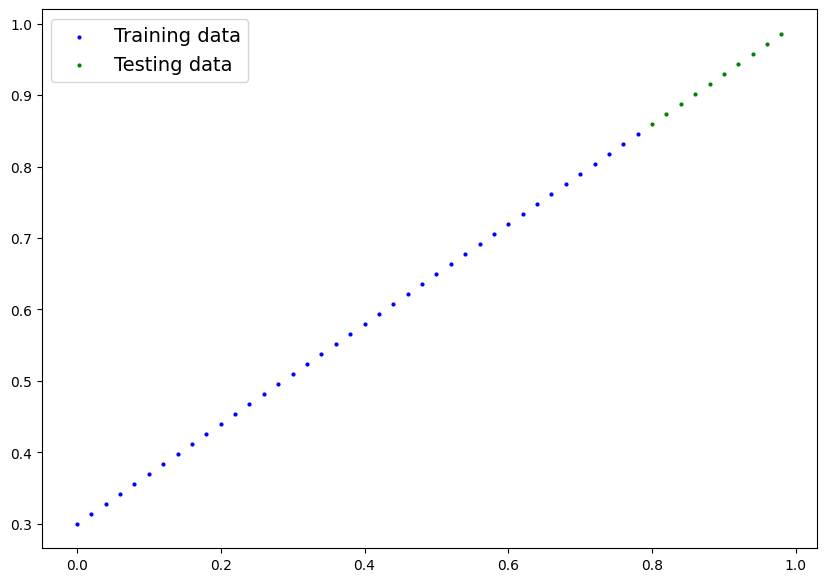

In [4]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):
    """绘制训练数据、测试数据并比较预测"""
    plt.figure(figsize=(10, 7))

    # 用蓝颜色描述训练数据
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")
    # 用绿颜色绘制测试数据
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    if predictions is not None:
        # 预测使用红颜色（预测是在测试数据上做出来的）
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

    # 显示图例
    plt.legend(prop={"size": 14})

plot_predictions()

可视化数据是处理数据的重要部分！！！

### 2. 构建模型
现在构建模型来使用蓝点预测绿点 

In [5]:
# 创建一个线性回归模型类
class LinearRegressionModel(nn.Module):# 几乎所有在pytorch的东西都是nn.Module(可以理解为它是神经网络的乐高积木)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float),  # 以随机权重开始，随着模型学习的进行，它将进行调整!
            requires_grad = True # 这表明是否可以用梯度下降更新权重
        )
        self.bias = nn.Parameter(torch.rand(1, dtype=torch.float), requires_grad=True)

    def forward(self, x:torch.tensor)-> torch.Tensor: # 'x'是输入（e.g.训练/测试特征） ->表示返回值return预期的类型是torch.Tensor
        return self.weights * x + self.bias # 这是线性方程'y = mx + b'



### PyTorch模型构建要点
PyTorch有四个基本模块，使用它们几乎可以构建所有想象的神经网络。

它们分别是`torch.nn`、`torch.optim`、`torch.urils.data.Dataset`和`torch.utils.data.DataLoader`。目前，将重点放在前两个，稍后在讨论另外两个。
* `torch.nn`: 包含计算图的所有构建块（本质上是一系列以特定方式执行的计算）。
* `torch.nn.Parameter`: 存储可以与`nn.Module`一起使用的张量。如果`requires_grad=True`梯度（用于通过梯度下降更新模型参数）被自动计算，这通常被称之为“自动求导”。
* `torch.nn.Module`: 所有神经网络模块的基类，所有神经网络的构建块都是子类。如果在Pytorch中构建神经网络，模型应该是`nn.Module`子类。需要实现一个`forward（）`方法。
* `torch.optim`： 包含各种优化算法（这些算法告诉存储在nn.Parameter中的模型参数如何最佳地改变以改善梯度下降，从而减少损失）。
* `def forward()`: 所有`nn.Module`子类都需要一个`forward()`方法，这定义了将对传递给特定`nn.Module`的数据进行的计算（例如，上方的线性回归公式）

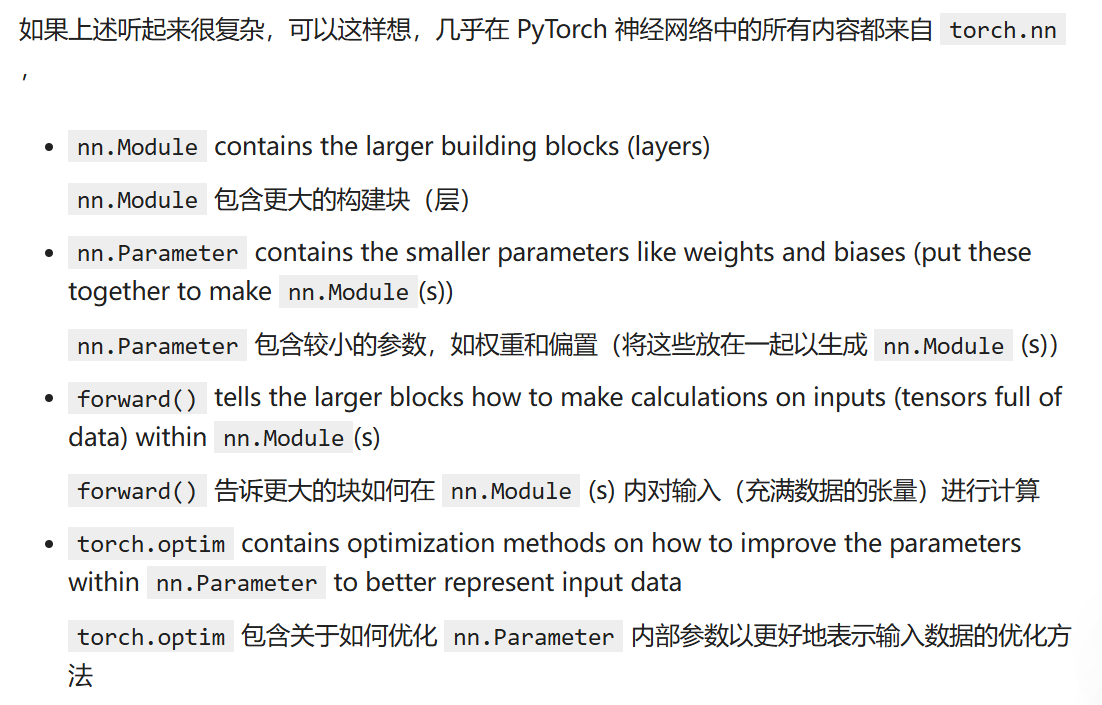

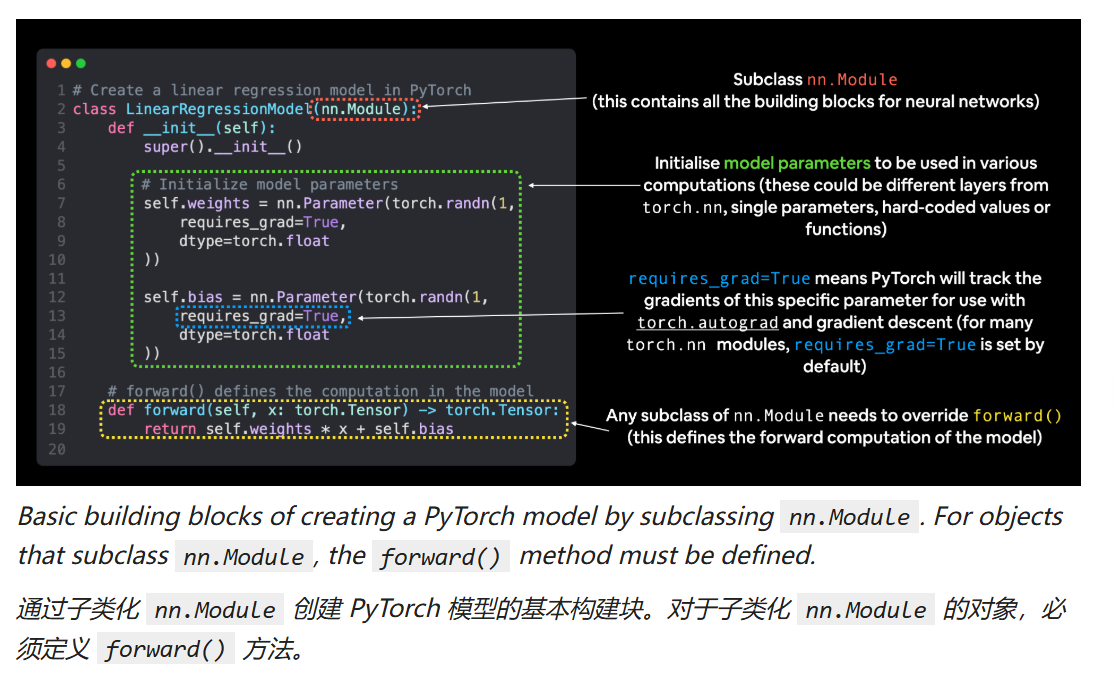

### 检查PyTorch模型的内容
现在用创建的类来创建一个模型的实例，并使用`.Parameters()`检查它的参数。

In [6]:
# 设置随机种子，因为`nn.Parameter`是随机初始化的。
torch.manual_seed(42)

# 创建一个模型的实例(这个nn.Module的子类包含nn.Parameter(s))
model_0 = LinearRegressionModel()

# 检查创建的nn.Module子类的nn.Parameter(s)
list(model_0.parameters()) 

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.3904], requires_grad=True)]

还可以使用`.state_dict()`来获取模型的状态（模型包含的内容）。

In [7]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.3904]))])

### 使用`torch.inference_mode()`进行预测
为了检查这一点，可以将测试数据`X_test`传递给它，已查看它预测`y_test`的准确程度。

当将数据传递给模型时，它将通过模型的`forward()`方法，并使用此方法定义的计算生成结果。

来做一些预测。

In [8]:
# 使用模型做一些预测
with torch.inference_mode():
    y_preds = model_0(X_test) 

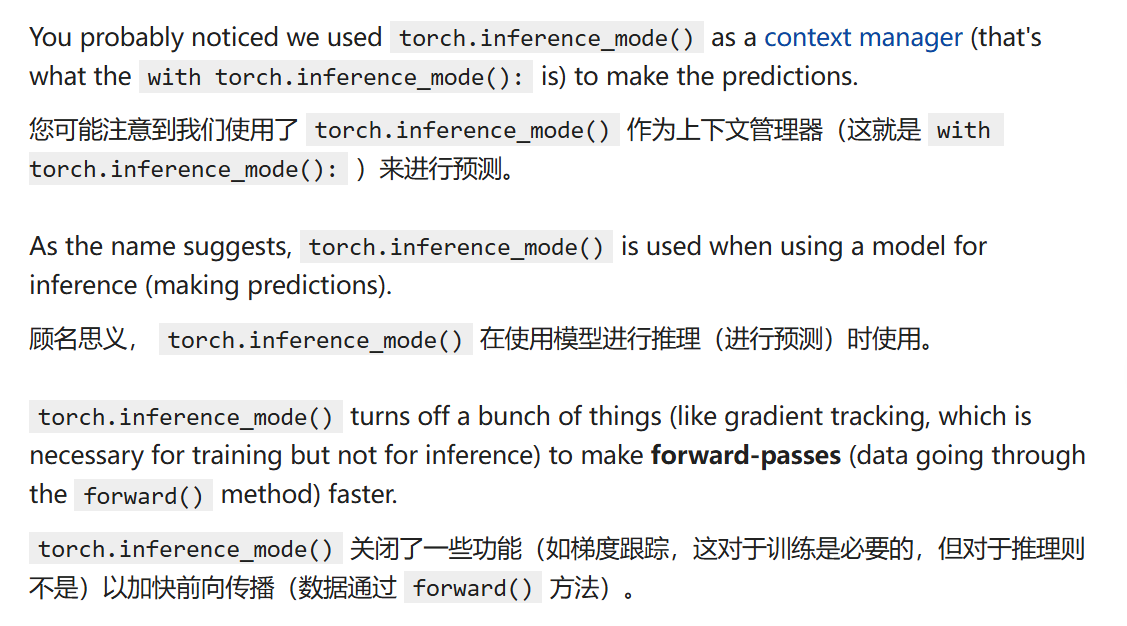

看一下预测是什么样的。

In [9]:
# 检查预测
print(f"测试样本的数量：{len(X_test)}")
print(f"样本预测的数量：{len(y_preds)}")
print(f"预测值：\n{y_preds}")

测试样本的数量：10
样本预测的数量：10
预测值：
tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])


使用`plot_predictions()`函数来可视化预测数据

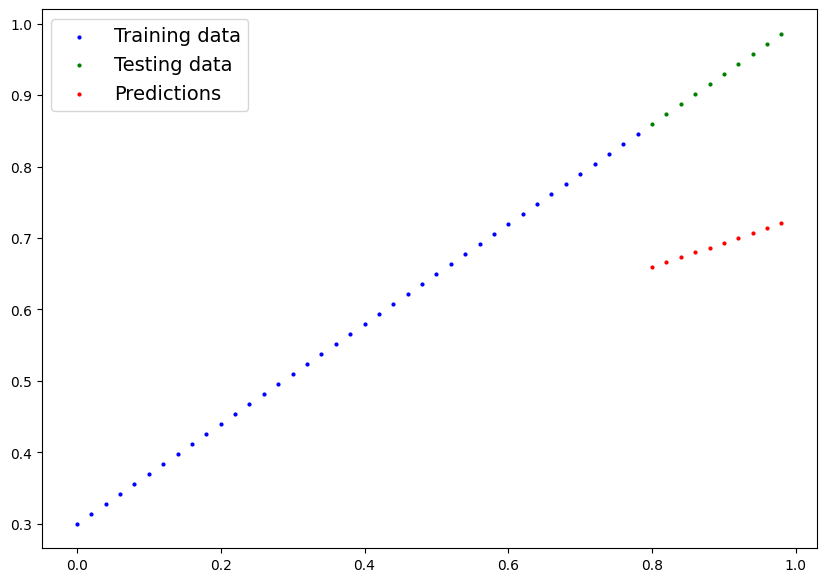

In [10]:
plot_predictions(predictions=y_preds)

In [11]:
y_test - y_preds

tensor([[0.2002],
        [0.2075],
        [0.2147],
        [0.2220],
        [0.2293],
        [0.2365],
        [0.2438],
        [0.2511],
        [0.2583],
        [0.2656]])

预测看起来很糟糕。

因为模型只是使用随机参数值来进行预测，甚至都没有查看蓝点以尝试测绿点。换句话说，还没用训练集来训练它。

下面开始训练模型

### 3. 训练模型
现在模型使用的随机参数进行预测，基本上是在随机猜测，所以误差相当大。

为了解决这个问题，可以更新其内部的参数（作者也将参数称之为模式），使用`nn.Parameter()`将`torch.randn()`随机设置的`weights`和`bias`值改为更好地代表数据的值。

## 在Pytorch中创建损失函数和优化器
为了让模型能自行更新参数，需要在配方中加入更多的内容。

这既是一个损失函数，也是一个优化器。

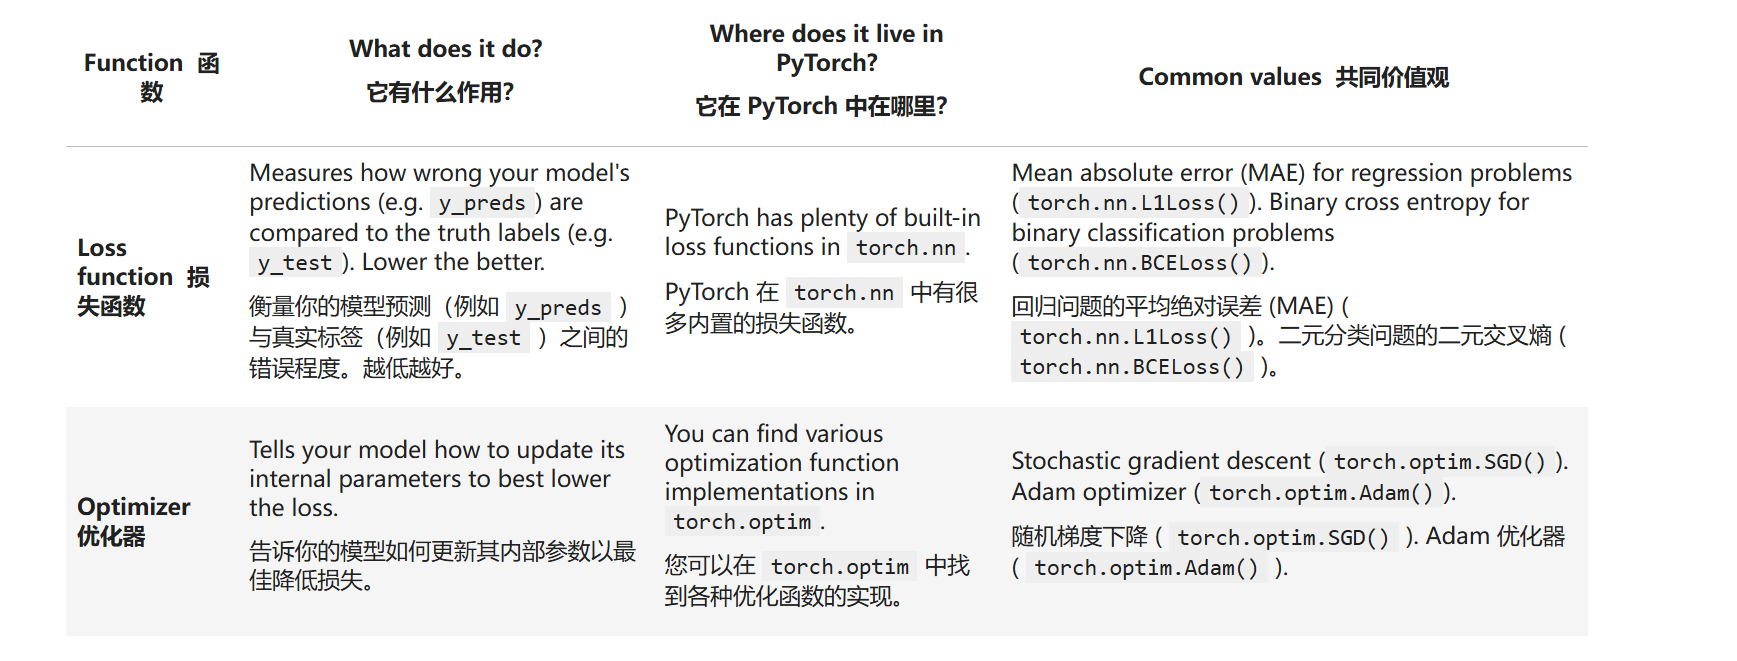

来创建一个优化器吧！来帮助改善模型。

根据处理问题的类型，将决定使用什么样的损失函数和什么优化器。

有一些常见的值，被认为效果良好，例如`SGD`或`Adam`优化器。对于回归问题（预测一个数字），使用`MAE`（平均绝对误差）损失函数；对于分类问题（预测某一事物），使用二元交叉熵损失函数。

对于上述的问题，是预测数字，所以使用MAE作为损失函数。在PyTorch中是(`torch.nn.L1Loss()`)。

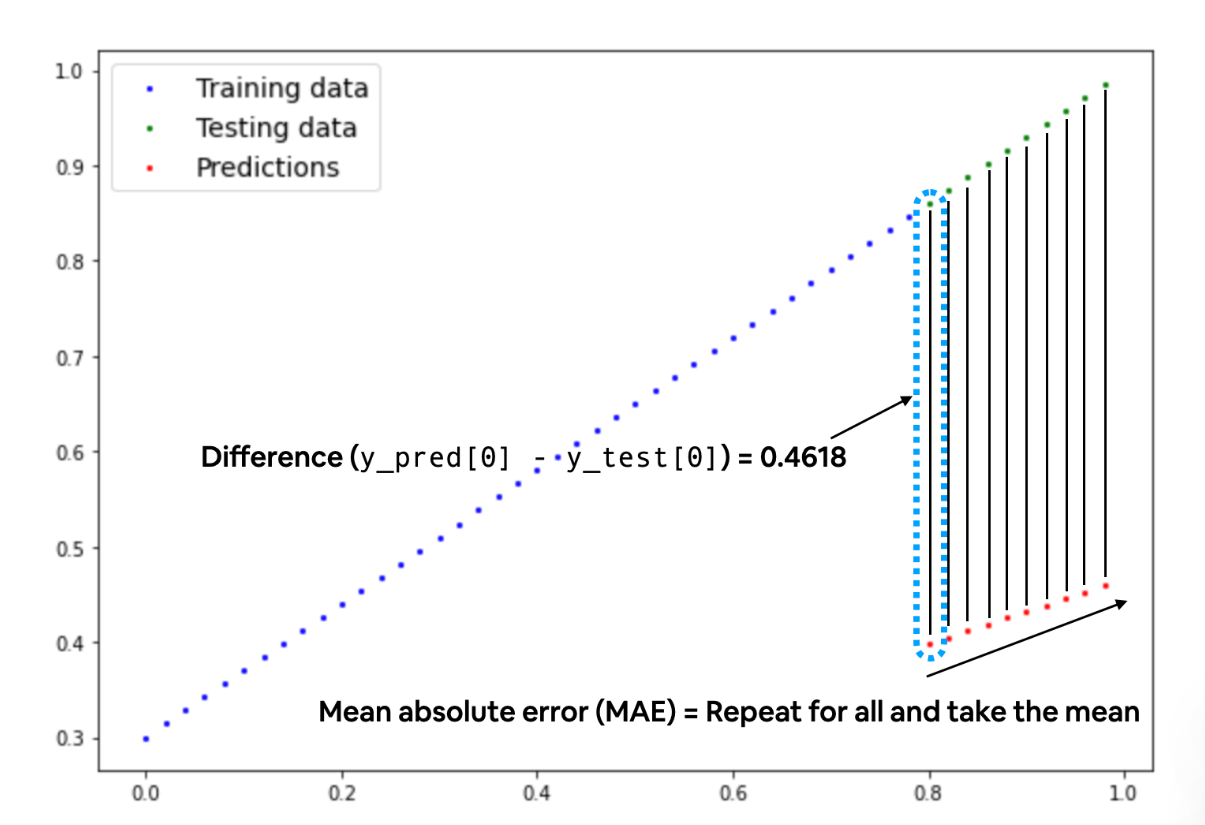

平均绝对误差（MAE，在 PyTorch 中： `torch.nn.L1Loss` ）衡量两个点（预测值和标签）之间的绝对差异，然后对所有示例取平均值。

对于优化器，将使用`SGD`。`torch.optim.SGD(params, lr)`其中：
* `params`是希望优化的目标模型参数（例如之前随机设置的`weights`和`bias`的值）。
* `lr`是希望优化器更新参数的学习率，较高的值意味着优化器将尝试更大的更新（这些更新有时可能过大，导致优化器无法正常工作），较低的值意味着优化器将尝试更小的更新（这些更新有时可能过小，导致优化器花费过长时间找到理想值）。学习率被视为超参数（因为它是由机器学习工程师设置的）。学习率的常见起始值为 `0.01` 、 `0.001` 、 `0.0001` ，然而，这些值也可以随着时间进行调整（这被称为学习率调度）。

In [12]:
# 创建损失函数
loss_fn = nn.L1Loss() # MAE 损失函数
# 创建优化器
optimizer = torch.optim.SGD(params=model_0.parameters(), # 这是优化目标模型参数 
                            lr=0.01) # 学习率（优化器在每一步应该改变参数的程度，较高=更多（不太稳定），较低=更少（可能需要更长时间））

## 在PyTorch中创建优化循环
训练循环涉及模型遍历训练数据集并学习`features`和`labels`之间的关系。

测试循环涉及遍历测试数据并评估模型在训练数据上学习到的模式的好坏（模型在训练期间从未看到测试数据）。

每个这些被称为“循环”，因为我们希望我们的模型查看（循环遍历）每个数据集中的每个样本。

## PyTorch训练循环
对于训练循环，我们将构建一下步骤：

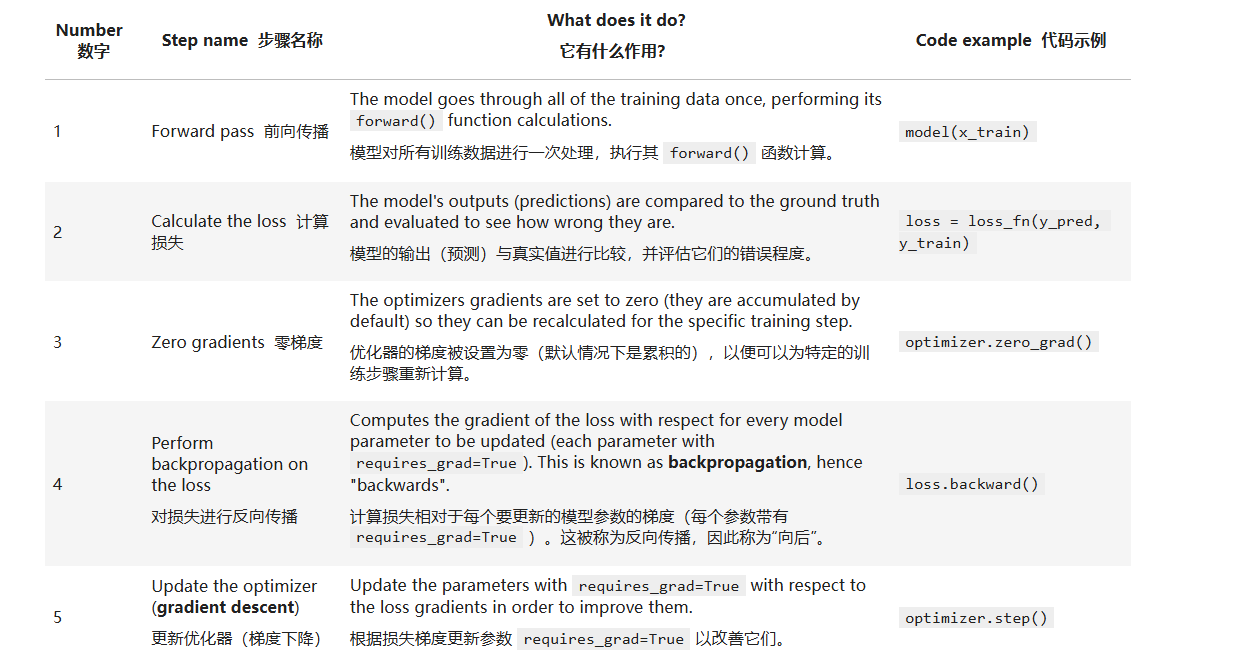

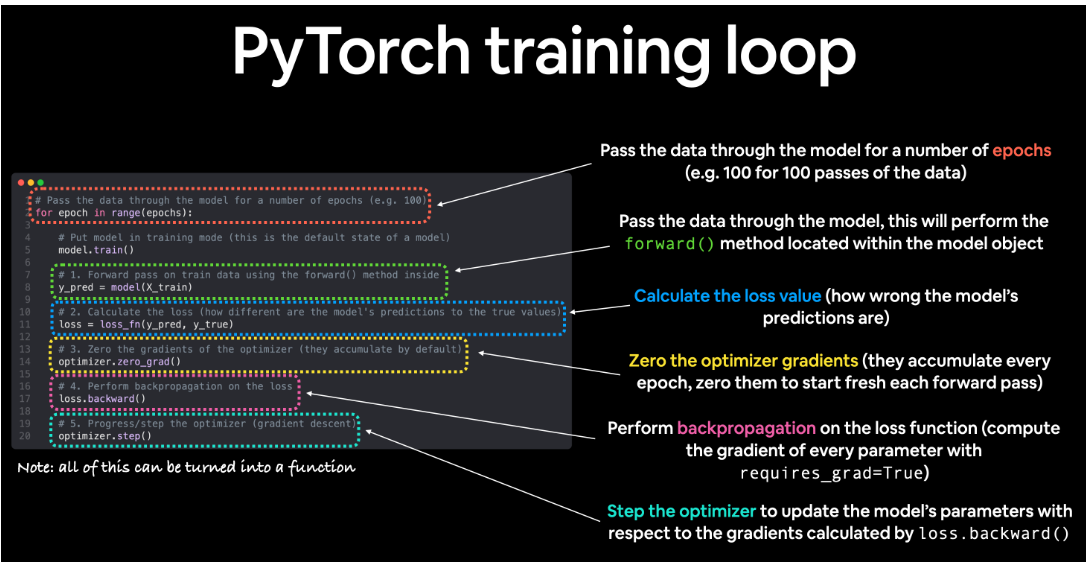

## 测试循环
至于测试循环，典型步骤如下：

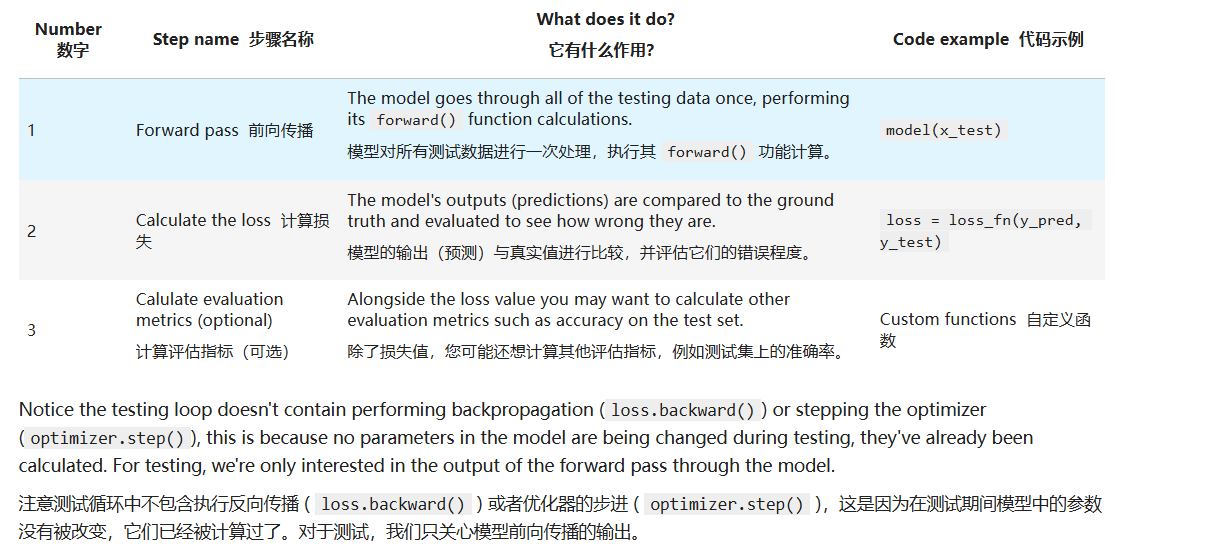

将上述步骤结合起来，然后训练模型100个epochs（对数据前向传播），并且每10个周期评估一次。

In [17]:
torch.manual_seed(42)

# 设置遍历数据的次数（epoch），意味着模型将遍历训练数据的次数
epochs = 100

# 创建空列表来存放数据
train_loss_values = []
test_loss_values = []
epoch_count = []

# 创建训练循环
for epoch in range(epochs):
    ### 训练过程

    # 将模型设置为训练模式（这是模型的默认状态）
    model_0.train()

    # 1. 使用前向传播方法向前传递输入数据
    y_pred = model_0(X_train)

    # 2. 计算损失（这是刻画预测值和真实值之间的差距，换而言之就是刻画模型的预测能力）
    loss = loss_fn(y_pred, y_train)

    # 3. 优化器是零梯度
    optimizer.zero_grad()

    # 4. 损失反向传播
    loss.backward()

    # 5. 优化器进度
    optimizer.step()

    ### 测试

    # 将模型调试为测试模式
    model_0.eval()

    with torch.inference_mode():
        # 1. 前向传播测试数据
        test_pred = model_0(X_test)

        # 2. 在测试数据上计算损失函数
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # 预测以torch.float数据类型出现，因此需要使用相同类型的张量进行比较。

        # 打印实验过程
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch：{epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch：0 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：10 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：20 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：30 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：40 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：50 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：60 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：70 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：80 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033
Epoch：90 | MAE Train Loss: 0.004964242689311504 | MAE Test Loss: 0.010411137714982033


损失在每个周期都在下降，绘制图表找一下原因

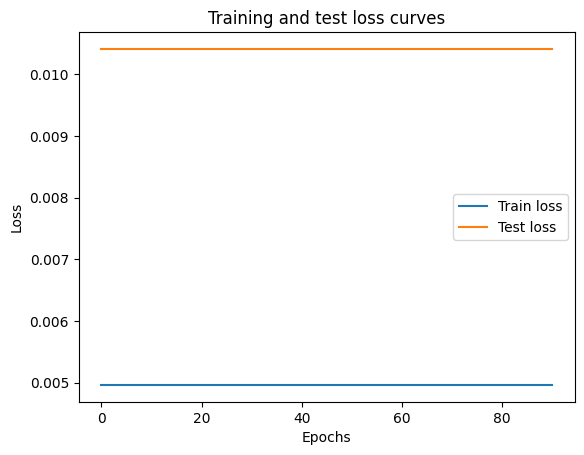

In [16]:
# 绘制损失曲线
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

查看预测值与原始值有多接近

In [18]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6962]), 'bias': tensor([0.3064])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4. 使用训练好的PyTorch模型进行预测
进行预测时，需要注意三件事：
1. 将模型设置为评估模式
1.